Load All the Initial Python Modules
 - astra_ctvlib is the core component that performs the GPU-tomography reconstuctions

In [2]:
import gpu_3D.Utils.astra_ctvlib as astra_ctvlib
import gpu_3D.Utils.pytvlib as pytvlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import h5py

In [3]:
# Auxilary Function to Visualize Slices of the Phantom Object or Reconstruction
def display_recon_slices(inVolume):

    fig, ax = plt.subplots(1,3,figsize=(25,25))
    ax = ax.flatten()
    ax[0].imshow(inVolume[127,],cmap='gray'); ax[0].axis('off')
    ax[1].imshow(inVolume[:,128,:],cmap='gray'); ax[1].axis('off')
    ax[2].imshow(inVolume[:,:,83],cmap='gray'); ax[2].axis('off')

### Simulating Projections 

Load the Input Dataset (commonly referered to as Tilt Series)

For this demo we'll show how we can use tomo_TV to generate these projections images from an input volume. 

For experimental reconstructions, skip this step and go straight to the reconstruction portion. 

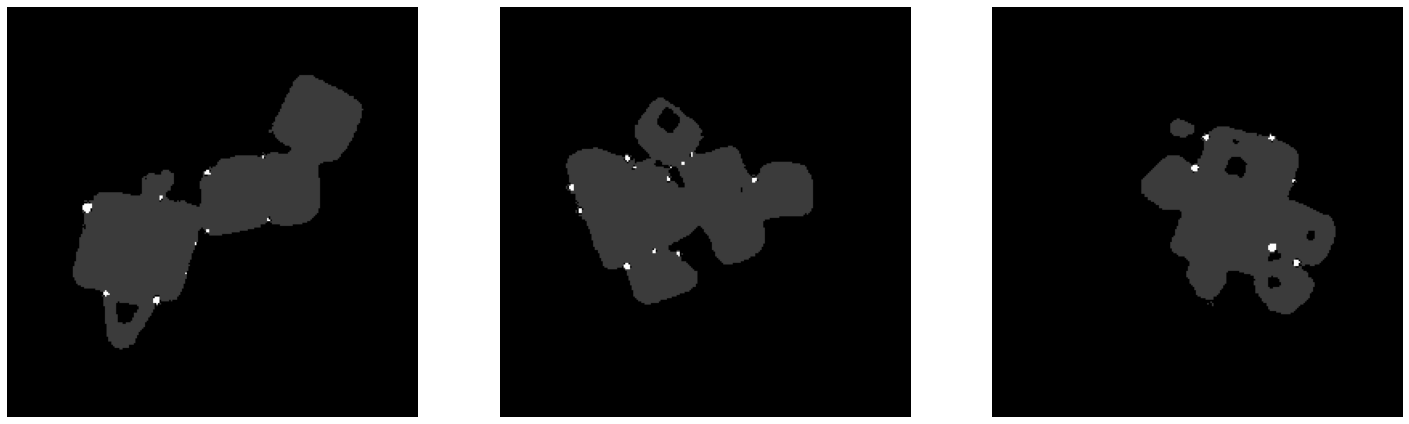

In [47]:
# Load the Original Volume
file = h5py.File('STO_nanocubes.h5','r')
original_volume = file['vol'][:]
file.close()

# Read Dimensions of Test Object
(Nslice, Nray, _) = original_volume.shape
# In cases where projection images aren't square: Nslice != Nray

# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(original_volume)) # Rescale to make visualization easier

Before Accessing any of the tomography functionality, we have to initialize the core class and any sub-functions that we would like to interface with.

To inialize this class we need to provide two parameters, 
1. The # of pixels of the projection images / volumes 

2. The tilt angles we would like to simulate the experiment, or angles that projection images were collected. 

In [6]:
# For this demo, we'll use conventional electron tomography experimental parameters: 
# ±70º with a +2º tilt increment. 
tiltAngles = np.arange(-70,72,2) 

# Initialize the C++ Object..
tomo = astra_ctvlib.astra_ctvlib(Nslice, Nray, np.deg2rad(tiltAngles))

# astra_ctvlib by default creates one 3D volume for the reconstruction, 
# any additional volumes needs to be externally intialized 
# (this is to save memory consumption)
tomo.initialize_initial_volume()

### Simulating Projections with a Test Object

<Figure size 1800x1800 with 0 Axes>

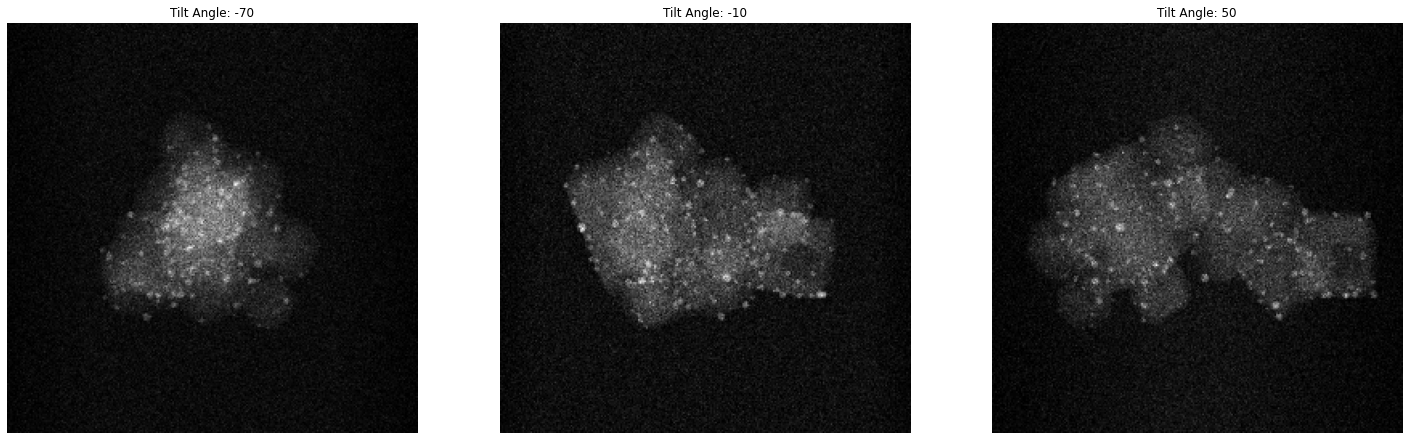

In [48]:
# Optional: Apply Poisson Noise to Background Volume
original_volume[original_volume == 0] = 1

# Let's pass the volume from python to C++  
for s in range(Nslice):
    tomo.set_original_volume(original_volume[s,:,:],s)

# Now Let's Create the Projection Images
tomo.create_projections()

# Optional: Apply poisson noise to volume.
SNR = 5
if SNR != 0: tomo.poisson_noise(SNR)

# Return the projections to Python
Nangles = tiltAngles.shape[0]
tiltSeries = np.zeros([Nslice, Nray, Nangles],dtype=np.float32)
projections = tomo.get_projections()

for i in range(Nangles):
    tiltSeries[:,:,i] = projections[:,Nray*i:Nray*(i+1)]

# Visualize Tilt Series
plt.figure(figsize=(25,25))
fig, ax = plt.subplots(1,3,figsize=(25,25))
ax = ax.flatten()
for j in range(3): 
    ax[j].imshow(tiltSeries[:,:,j*30],cmap='gray'); 
    ax[j].axis('off'); 
    ax[j].set_title('Tilt Angle: ' + str(tiltAngles[j*30]))

### Passing Experimental Projections into tomo_TV

Refer to the following cell to pass experimental projections to tomo_TV. 

We assume the tilt-axis is along the first dimension. 

In [ ]:
file = h5py.File('au_sto_tilt_series.h5','r')
tiltSeries = file['tiltSeries'][:]
tiltAngles = file['tiltAngles'][:]
file.close()

# tiltSeries.shape = (Nslice, Nray, Nangles)
# tiltAngles.shape = (NAngles,)

# Create Projections Vector
b = np.zeros([Nslice, Nray*Nangles])
for s in range(Nslice):
    b[s,:] = tiltSeries[s,:,:].transpose().ravel()
    
# Pass the Tilt Series to tomo_TV C++ object.
tomo.set_tilt_series(b)

### Tomography Recontructions

Now that we have a sample tilt series, let's actually reconstruct the data and see how it compares to the ground truth

FBP Filter: ram-lak


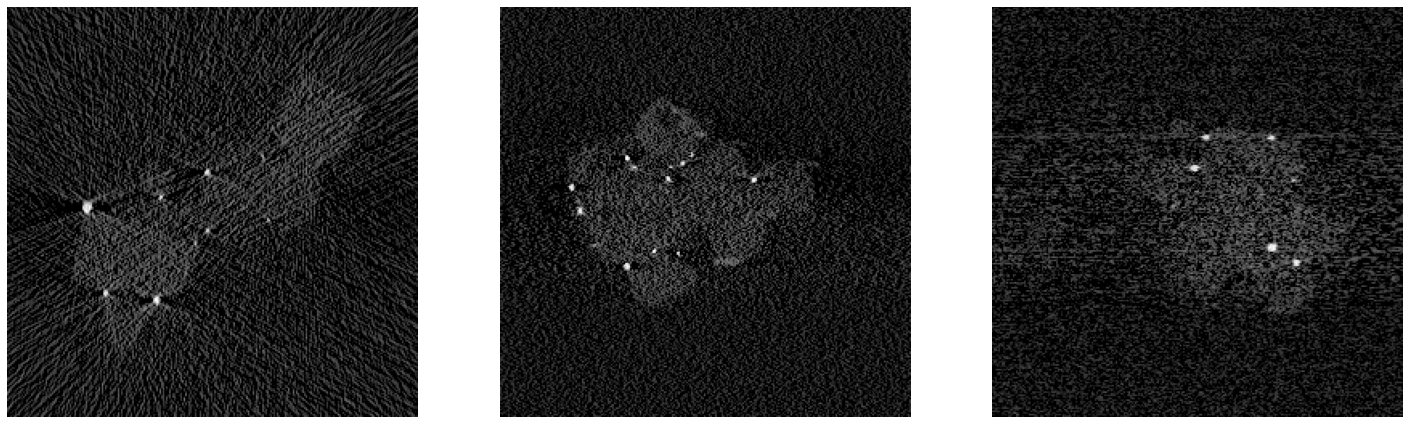

In [29]:
# We have quite a few algorithms to choose from, for simplicitiy let's start off with FBP

# Start off by initializing the FBP reconstruction operator
filter = 'ram-lak' 
tomo.initialize_FBP(filter)
# other filter options include: 
# none, ram-lak, shepp-logan, cosine, hamming, hann, tukey, lanczos,
# triangular, gaussian, barlett-hann, blackman, nuttall, blackman-harris,
# blackman-nuttall, flat-top, kaiser, parzen

# Reconstruct the Data
tomo.FBP(True) # Input Boolean Decides whether we want to apply positivity after backprojecting the data. 
    
# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

Oof, as expected FBP is terrible. Let's now try an iterative algorithm like SIRT. 

100%|██████████| 150/150 [00:17<00:00,  8.39it/s]


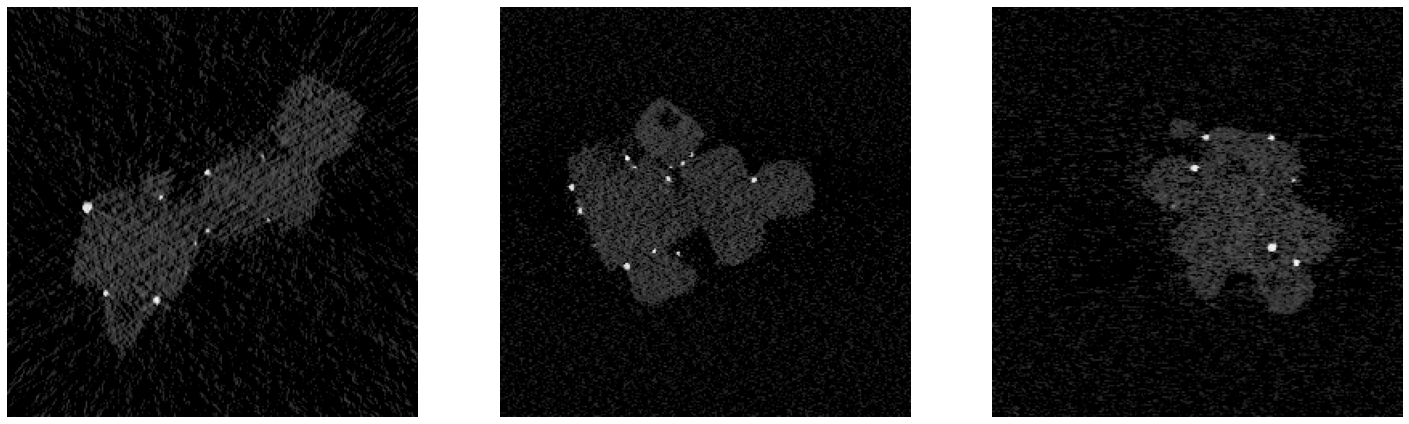

In [49]:
# Start off by initializing the SIRT reconstruction operator
Niter = 150
tomo.initialize_SIRT()

# Main Loop
for i in tqdm(range(Niter)):
    tomo.SIRT(1) # Number of iterations we would like to call 
    
# Return the Reconstruction to Python
recon = np.zeros([Nslice,Nray,Nray],dtype=np.float32)
for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

Wow! So much better. We can also add regularization and try clean up the reconstructions further

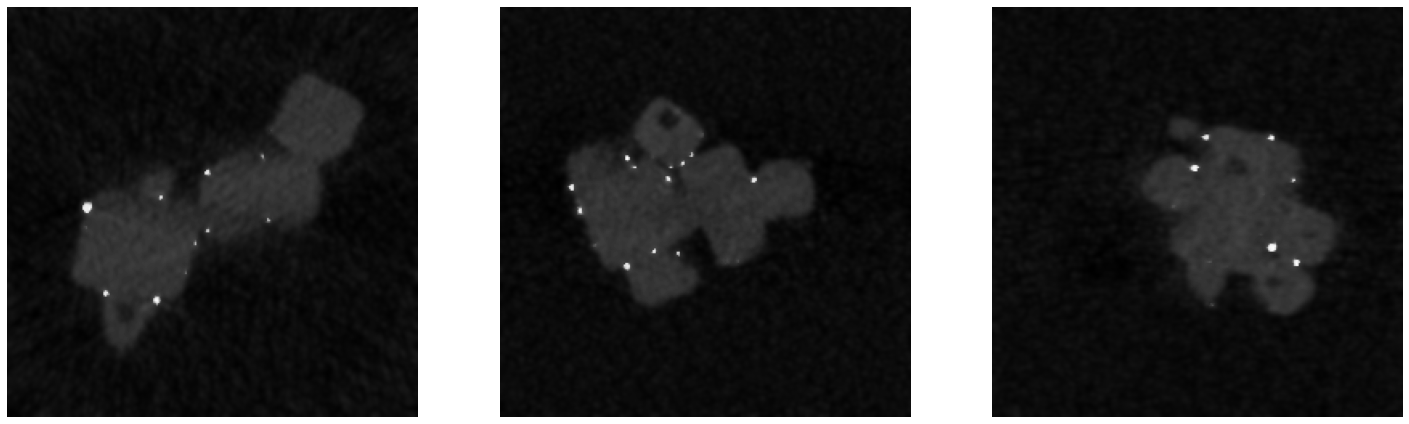

In [50]:
# Number of TV Iterations
nTViter = 25

# Lambda Parameter
tvLambda = 15

# This is the Fast Gradient Projection Method for Solving TV Denoising
tomo.tv_fgp(nTViter, tvLambda)

for s in range(Nslice):
    recon[s,] = tomo.get_recon(s)
    
# Visualize Slices of the Phantom Object
display_recon_slices(np.sqrt(recon))

Not bad! We could try a combination of Various Approaches. Feel free to try other algorithms. 